### Question

**Find the friend from which the sum of distances to other friends is the least.**

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
names = ['Bob','David','Mary','Skyler']
locations = np.array([[4, 5, 6], [10, 12, 20], [45, 60, 61], [89, 17, 51]])

friends = list(map(lambda x, y: {'name': x, 'location': y.tolist()}, names, locations))
friends

[{'name': 'Bob', 'location': [4, 5, 6]},
 {'name': 'David', 'location': [10, 12, 20]},
 {'name': 'Mary', 'location': [45, 60, 61]},
 {'name': 'Skyler', 'location': [89, 17, 51]}]

#### Approach 1: Brute-Force solution
Quadratic Time Complexity

In [3]:
def calculate_distance(loc1, loc2):
    (x1,y1,z1)=loc1
    (x2,y2,z2)=loc2
    return ((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)**(1/2)

def calculate_total_distance(friend, friends):
    return sum(map(lambda x: calculate_distance(friend['location'], x['location']), friends))
    
def find_all_distance(friends):
    return list(map(lambda x: calculate_total_distance(x,friends), friends))

def find_host(friends):
    names = list(map(lambda x: x['name'], friends))
    name_distance = np.vstack((names, find_all_distance(friends))).transpose()
    
    result = name_distance[np.argsort(name_distance[:,1].astype('float'))][0]
    return result[0], result[1]
    
result = find_host(friends)
result

('David', '173.9551482365431')

#### Approach 2: Geometric Mean

Sum of distances and sum of squares of distances are both monotonically increasing functions. 

If we were to minimize the sum of squares of distances instead of sum of distances, the optimum solution will be the **centroid** (can be theoretically found).

And so, an imperfect solution would be to find the closest point to the centroid since we require our point to be one of the friends' house.

In [4]:
def find_total_distance(host_name, names, locations):
    host_idx = names.index(host_name)
    final_dist = np.sum(np.sqrt(np.sum((locations - locations[host_idx])**2, axis=1)))
    return final_dist

locations = np.array(list(map(lambda x: x['location'], friends)))

(p,q,r) = np.mean(locations[:,0]), np.mean(locations[:,1]), np.mean(locations[:,2])

def get_distance(v1,v2):
    return sum((v1-v2)**2)

names = list(map(lambda x: x['name'], friends))

dist_from_center = np.array(list(map(lambda x: get_distance(x, np.array([p,q,r])), locations)))
dist_from_center = np.vstack((names, dist_from_center)).transpose()

result = dist_from_center[np.argsort(dist_from_center[:,1].astype('float'))][0]
host_name = result[0]
final_dist = find_total_distance(host_name, names, locations)
host_name, final_dist

('David', 173.9551482365431)

#### Approach 3: Geometric Median

Consider a case when all the points are on a line. The least sum of distances (absolute/manhattan distance in this case) will be for the point that is **median** of numbers. This can be mathematically proved.

In [5]:
data = [2,5,6,3,7,8,93,35]

def calculate_abs_distance(i,j):
    return abs(i-j)
   
def total_abs_distance(datapoint, data): 
    return sum(map(lambda x: calculate_abs_distance(datapoint, x), data))
    
distances = list(map(lambda x: total_abs_distance(x,data), data))

data_dist = (np.vstack((data,distances)).transpose())

result = data_dist[np.argsort(data_dist[:,1])][0]
result[0]

6

However, since our points are in N-dimensional space, we need to calculate something commonly called as **geometric median.**

In [6]:
def cost(coords, x):
    return np.sum(np.sqrt(np.sum((coords-x)**2, axis=1)))

coords = locations
obj_func = lambda x: cost(coords, x)
x0 = np.mean(coords, axis=0)
sol = minimize(obj_func, x0)
sol

      fun: 173.83661491420048
 hess_inv: array([[25.11424771,  7.94254557,  5.75802883],
       [ 7.94254557,  4.91473555,  2.25753466],
       [ 5.75802883,  2.25753466,  3.92417124]])
      jac: array([ 1.90734863e-06,  0.00000000e+00, -3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 72
      nit: 15
     njev: 18
   status: 0
  success: True
        x: array([12.291911  , 12.73431524, 20.39395965])

In [7]:
def closest_host(coords, x):
    dists = np.sqrt(np.sum((coords - x)**2, axis=1))
    host_idx = np.argsort(dists)[0]
    host_name = names[host_idx]
    return host_name
    
x = sol.x
host_name = closest_host(coords, x)
final_dist = find_total_distance(host_name, names, locations)
host_name, final_dist

('David', 173.9551482365431)

In [8]:
def loss_fn(coords, x):
    return np.sum(np.sqrt(np.sum((coords-x)**2, axis=1)))

def gradient(coords, x):
    dx = 0
    dy = 0
    dz = 0
    for pt in coords:
        dist = np.sqrt((pt[0] - x[0])**2 + (pt[1] - x[1])**2 + (pt[2]-x[2])**2)
        dx += -1 * (pt[0] - x[0]) / dist
        dy += -1 * (pt[1] - x[1]) / dist
        dz += -1 * (pt[2] - x[2]) / dist
    return dx, dy, dz

def gradient_descent(coords, x_init, alpha, eps):
    x = x_init
    dx = 1
    dy = 1
    dz = 1
    
    costs = []
    n_iters = 0
    while np.linalg.norm(dx) > eps and np.linalg.norm(dy) > eps and np.linalg.norm(dz) > eps:
        dx, dy, dz = gradient(coords, x)
        x[0] = x[0] - alpha * dx
        x[1] = x[1] - alpha * dy
        x[2] = x[2] - alpha * dz

        cost = loss_fn(coords, x)
        costs.append(cost)
        n_iters += 1

        if n_iters%2000==0:
            print(f'Iteration: {n_iters} | Cost: {cost.round(3)}')
    print(f'Iteration: {n_iters} | Cost: {cost.round(3)}')
    return x, costs

x_init = np.mean(coords, axis=0)
alpha = 1E-2
eps = 1E-3
x, costs = gradient_descent(coords, x_init, alpha, eps)
print('\n', 'Geometric Median:', x)

Iteration: 2000 | Cost: 178.135
Iteration: 4000 | Cost: 176.543
Iteration: 6000 | Cost: 175.487
Iteration: 8000 | Cost: 174.776
Iteration: 10000 | Cost: 174.317
Iteration: 12000 | Cost: 174.049
Iteration: 14000 | Cost: 173.917
Iteration: 16000 | Cost: 173.863
Iteration: 18000 | Cost: 173.844
Iteration: 20000 | Cost: 173.839
Iteration: 22000 | Cost: 173.837
Iteration: 23210 | Cost: 173.837

 Geometric Median: [12.40198385 12.77349318 20.42296289]


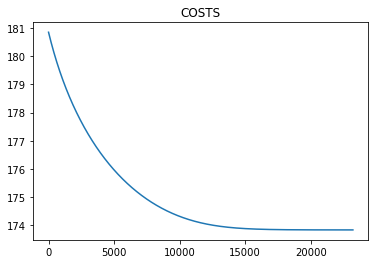

In [9]:
plt.plot(costs)
plt.title('COSTS')
plt.show()

In [10]:
host_name = closest_host(coords, x)
final_dist = find_total_distance(host_name, names, locations)
host_name, final_dist

('David', 173.9551482365431)